In [2]:
!pip install xgboost shap --quiet


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import shap


In [4]:
from google.colab import files
uploaded = files.upload()  # Upload `fixed_income.csv`

df = pd.read_csv('/content/fixed_income.csv')
df.head()


Saving fixed_income.csv to fixed_income (2).csv


,Unnamed: 0,Financial Instrument,Coupon,Maturity,Ratings,Issuer Debt/Equity,Issue Date,Time-To-Maturity (TTM),Payment Frequency,Ask,Ask Yield,Duration %,Convexity,Bid,Unnamed: 13,Instrument Type
0,0,SMMSBK CORP CD 82869ADY8,5.45,Jul25'24,0,0,Oct 25 '23,0.01,Monthly,100.005,3.511,0.005479452200233936,0.0000003,99.851,0.0,Certificates of Deposit
1,1,BRISBK CORP CD 110001AS3,5.30,Jul26'24,0,0,Jul 28 '23,0.01,Monthly,99.998,5.645,0.008219177834689617,0.00000068,99.850,0.0,Certificates of Deposit
2,2,SYF CORP CD 87164WN95,3.30,Jul29'24,0,0,Jul 29 '22,0.02,Semi-Annual,99.967,5.628,0.016438355669379234,0.0000027,99.813,0.0,Certificates of Deposit
3,3,FBFCEN CORP CD 319267KV1,5.25,Jul29'24,0,0,Jun 29 '23,0.02,Semi-Annual,99.995,5.596,0.016438355669379234,0.0000027,99.846,0.0,Certificates of Deposit
4,4,COF CORP CD 14042TJA6,3.35,Aug05'24,0,0,Aug 03 '22,0.04,Semi-Annual,99.921,5.689,0.5218930244445801,0.0027642634231597185,99.881,0.0,Certificates of Deposit


In [10]:
# Convert relevant columns to numeric
# Adjust column names if necessary to match your CSV file
# Check if 'Duration %' or 'Duration' exists, use actual name
duration_col = None
for col in ['Duration %', 'Duration']:  # Check both possibilities
    if col in df.columns:
        duration_col = col
        break  # Stop if found

if duration_col is not None:  # proceed if either column exists
    df[duration_col] = pd.to_numeric(df[duration_col].str.strip(), errors='coerce')  # Strip leading/trailing spaces

df['Convexity'] = pd.to_numeric(df['Convexity'].str.strip(), errors='coerce')  # Strip leading/trailing spaces
df['Bid'] = pd.to_numeric(df['Bid'].str.strip(), errors='coerce')  # Strip leading/trailing spaces
df['Issuer Debt/Equity'] = pd.to_numeric(df['Issuer Debt/Equity'].str.strip(), errors='coerce')  # Strip leading/trailing spaces

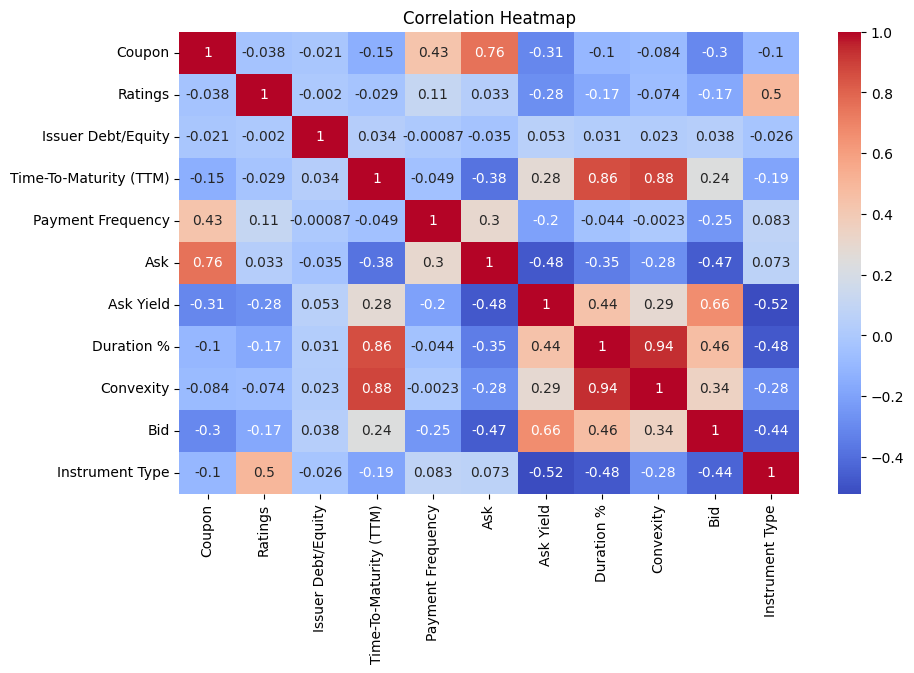

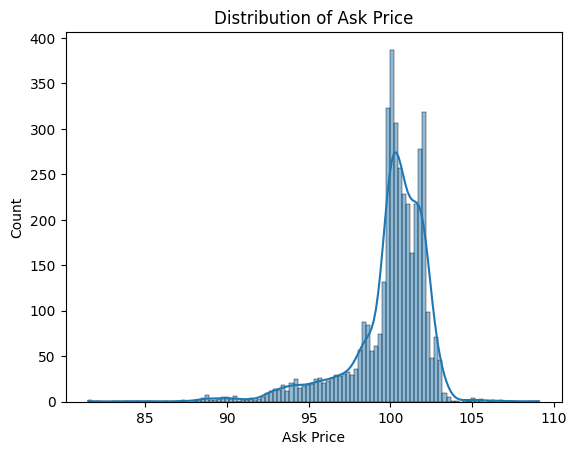

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Distribution of Ask Prices
sns.histplot(df['Ask'], kde=True)
plt.title("Distribution of Ask Price")
plt.xlabel("Ask Price")
plt.show()


In [18]:
# Train-test split
# Re-assemble the scaled data with any non-numeric features
# Assuming X and y are defined before this cell

# Separate numeric and non-numeric features for scaling
X_numeric = X.select_dtypes(include=np.number)
X_non_numeric = X.select_dtypes(exclude=np.number)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)


# Split data BEFORE scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Now scale the numeric features of X_train and X_test
X_train_num = scaler.transform(X_train.select_dtypes(include=np.number))
X_test_num = scaler.transform(X_test.select_dtypes(include=np.number))


# Assuming there are non-numeric features you want to include
# If not, you can skip this part and just use X_train_num, X_test_num
non_numeric_features = X.select_dtypes(exclude=np.number).columns

# Get the original indices from before scaling
# Instead of using X_train_num directly, use its row indices
train_indices = X_train.index
test_indices = X_test.index

# Now you can use .loc to select rows from the original DataFrame
X_train_non_num = X.loc[train_indices, non_numeric_features]
X_test_non_num = X.loc[test_indices, non_numeric_features]

# Concatenate for final training and testing sets
# Ensure X_train_num and X_test_num are DataFrames before concatenating
X_train_num = pd.DataFrame(X_train_num, columns=X_numeric.columns, index=X_train.index) # add index here
X_test_num = pd.DataFrame(X_test_num, columns=X_numeric.columns, index=X_test.index) # add index here
X_train = pd.concat([X_train_num, X_train_non_num], axis=1)
X_test = pd.concat([X_test_num, X_test_non_num], axis=1)

In [ ]:
# Evaluation
# rmse_xgb = mean_squared_error(y_test, xgb_preds, squared=False) # This line caused the error
# Instead of using 'squared=False', calculate RMSE manually:
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_preds))
r2_xgb = r2_score(y_test, xgb_preds)
print(f"XGBoost - RMSE: {rmse_xgb:.4f}, R²: {r2_xgb:.4f}")

XGBoost - RMSE: 0.2676, R²: 0.9900


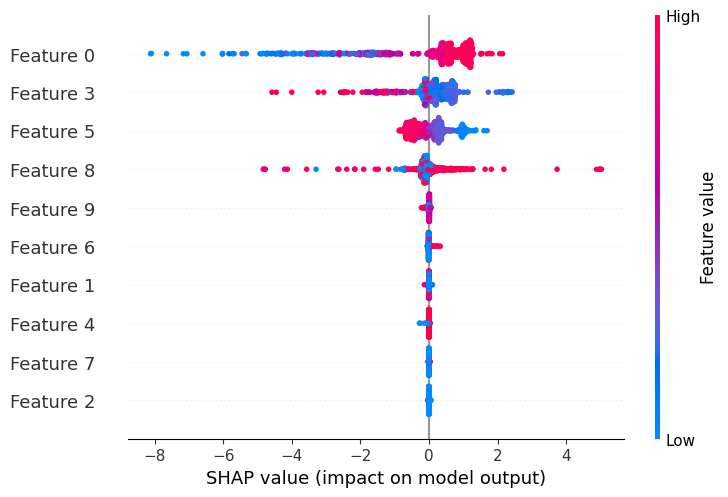

In [ ]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)


SVR - RMSE: 0.1827, R²: 0.9953


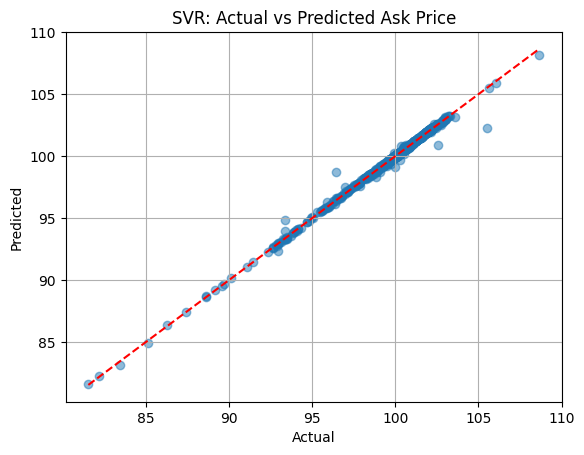

In [ ]:
svr = SVR(kernel='rbf', C=100)
svr.fit(X_train, y_train)
svr_preds = svr.predict(X_test)

# Instead of using 'squared=False', calculate RMSE manually:
rmse_svr = np.sqrt(mean_squared_error(y_test, svr_preds))
r2_svr = r2_score(y_test, svr_preds)
print(f"SVR - RMSE: {rmse_svr:.4f}, R²: {r2_svr:.4f}")

# Plot
plt.scatter(y_test, svr_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("SVR: Actual vs Predicted Ask Price")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
ANN - RMSE: 1.9770, R²: 0.4525


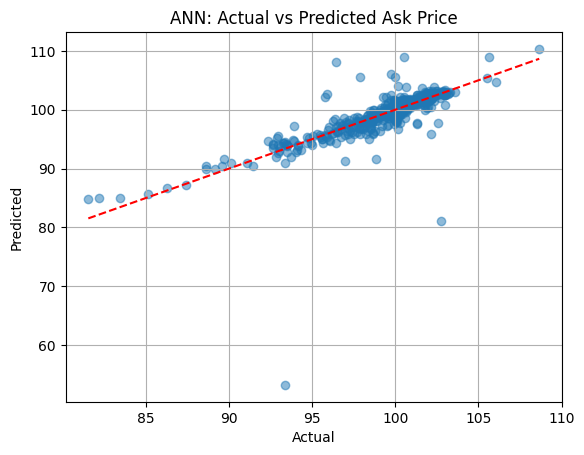

In [ ]:
ann_preds = ann.predict(X_test).flatten()
# rmse_ann = mean_squared_error(y_test, ann_preds, squared=False) # This line caused the error
# Calculate RMSE manually using NumPy's sqrt function:
rmse_ann = np.sqrt(mean_squared_error(y_test, ann_preds))
r2_ann = r2_score(y_test, ann_preds)
print(f"ANN - RMSE: {rmse_ann:.4f}, R²: {r2_ann:.4f}")

# Plot
plt.scatter(y_test, ann_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("ANN: Actual vs Predicted Ask Price")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

     Model      RMSE  R2 Score
0  XGBoost  0.267617  0.989968
1      SVR  0.182678  0.995326
2      ANN  1.976999  0.452521


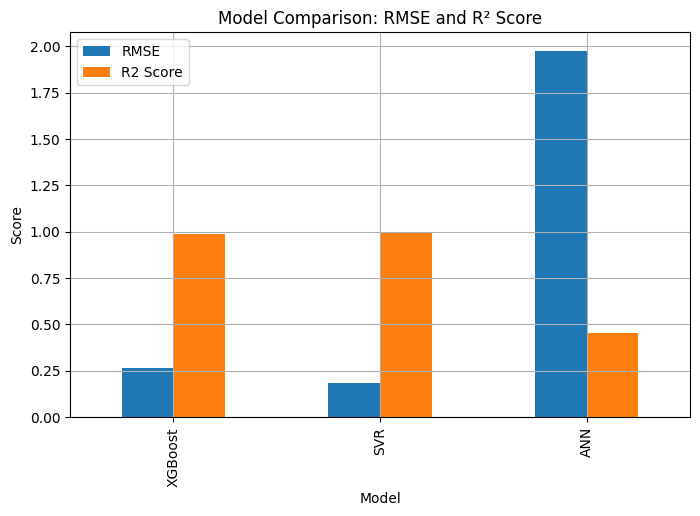

In [ ]:
results = pd.DataFrame({
    'Model': ['XGBoost', 'SVR', 'ANN'],
    'RMSE': [rmse_xgb, rmse_svr, rmse_ann],
    'R2 Score': [r2_xgb, r2_svr, r2_ann]
})

print(results)

# Bar Plot
results.set_index('Model')[['RMSE', 'R2 Score']].plot(kind='bar', figsize=(8, 5))
plt.title("Model Comparison: RMSE and R² Score")
plt.ylabel("Score")
plt.grid(True)
plt.show()


In [28]:
import numpy as np

# Function: Present Value of a bond using traditional DCF approach
def dcf_valuation(face_value, coupon_rate, ttm, frequency, discount_rate):
    periods = int(ttm * frequency)
    # Check if periods is 0 and handle the case
    if periods == 0:
        return face_value  # If TTM is 0, return face value
    coupon = face_value * (coupon_rate / 100) / frequency
    cash_flows = [coupon] * periods
    cash_flows[-1] += face_value  # add face value to last payment
    discount_factors = [(1 + discount_rate / frequency)**-i for i in range(1, periods + 1)]
    return sum([cf * df for cf, df in zip(cash_flows, discount_factors)])

# Apply to dataset
df['DCF_Price'] = df.apply(
    lambda row: dcf_valuation(100, row['Coupon'], row['Time-To-Maturity (TTM)'],
                              12 if row['Payment Frequency'] == 'Monthly' else 2,
                              row['Ask Yield'] / 100), axis=1)

# Show comparison
df[['Ask', 'DCF_Price']].head()

,Ask,DCF_Price
0,100.005,100.0
1,99.998,100.0
2,99.967,100.0
3,99.995,100.0
4,99.921,100.0


In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

# Example ANN model (retrain as needed)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming history = model.fit(..., return_history=True)
# Fit the model and store the training history
# history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, return_history=True)  # Adjust epochs and validation_split as needed
# Remove return_history=True as it's not a valid argument for model.fit()
# Before fitting the model, check if X_train has any non-numeric columns:
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns

# If there are non-numeric columns, encode them:
for col in non_numeric_cols:
    # Create a combined set of unique values from both train and test
    unique_values = pd.concat([X_train[col], X_test[col]]).astype(str).unique()

    le = LabelEncoder()
    # Fit the LabelEncoder on the combined unique values
    le.fit(unique_values)

    X_train[col] = le.transform(X_train[col].astype(str)) # Convert to string before encoding
    X_test[col] = le.transform(X_test[col].astype(str)) # Use the same encoder on the test set and convert to string

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)  # Adjust epochs and validation_split as needed

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: nan - val_loss: nan
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: nan - val_loss: nan
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: nan - val_loss: nan
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: nan - val_loss: nan
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: nan - val_loss: nan
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: nan - val_loss: nan
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: nan - val_loss: nan
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan - val_loss: nan
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan


In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder here
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

# Create a LabelEncoder instance outside the loop, one for each categorical column
label_encoders = {}

for col in X.select_dtypes(include=['object']).columns:
    label_encoders[col] = LabelEncoder()

for train_idx, test_idx in kf.split(X):
    # Use .iloc to select rows based on indices:
    X_tr, X_te = X.iloc[train_idx].copy(), X.iloc[test_idx].copy() # Create copies to avoid modifying original DataFrame
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # Encode non-numeric columns within the loop for both train and test sets
    for col in X_tr.select_dtypes(include=['object']).columns:
        # Fit on the training data and transform both
        # use the encoder specific to the column
        X_tr[col] = label_encoders[col].fit_transform(X_tr[col].astype(str))

        # Get all unique values from both train and test
        all_values = list(set(X_tr[col].astype(str).unique()).union(set(X_te[col].astype(str).unique())))

        # Update the encoder's classes_ to include all values
        label_encoders[col].classes_ = np.array(all_values, dtype=label_encoders[col].classes_.dtype)

        # transform test set using the column specific encoder
        X_te[col] = label_encoders[col].transform(X_te[col].astype(str)) # Use the same encoder for test set

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_tr.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_tr, y_tr, epochs=20, verbose=0)

    preds = model.predict(X_te)

    # Check and handle NaN in preds and y_te before calculating MSE

    #Option 1: Remove rows with NaNs
    # mask = np.isnan(preds).any(axis=1) | np.isnan(y_te) #create a combined mask of Nan values
    # y_te = y_te[~mask] #apply the mask to y_te
    # preds = preds[~mask] #apply the mask to predictions

    #Option 2: Replace with 0 or a chosen value
    preds = np.nan_to_num(preds, nan=0)  # Replace NaNs in preds with 0
    y_te = np.nan_to_num(y_te, nan=0)  # Replace NaNs in y_te with 0

    mse_scores.append(mean_squared_error(y_te, preds))

print(f"Avg MSE across folds: {np.mean(mse_scores):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Avg MSE across folds: 10008.1996


In [41]:
from sklearn.model_selection import train_test_split

X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:
from keras.layers import Input


In [46]:
from sklearn.preprocessing import LabelEncoder

# Copy original data
data = df.copy()

# Select relevant features and target
features = ["Coupon", "Time-To-Maturity (TTM)", "Ask Yield", "Payment Frequency", "Instrument Type"]
target = "Ask"

# Encode categorical variables
label_enc = LabelEncoder()
data["Payment Frequency"] = label_enc.fit_transform(data["Payment Frequency"])
data["Instrument Type"] = label_enc.fit_transform(data["Instrument Type"])

# Define X and y
X = data[features].astype(float)
y = data[target].astype(float)

# Train-test split
from sklearn.model_selection import train_test_split
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
from sklearn.model_selection import train_test_split, ParameterGrid
from keras.models import Sequential
from keras.layers import Dense, Input

# Split your features and target first (if not already done)
# Example:
# X = df[["Coupon", "Time-To-Maturity (TTM)", "Ask Yield"]]  # or whatever you're using
# y = df["Ask"]  # or your target column

# Split for validation
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid search space
param_grid = {
    'units': [32, 64],
    'activation': ['relu', 'tanh'],
    'epochs': [10, 20]
}

best_mse = float('inf')
best_config = None

# Hyperparameter tuning loop
for params in ParameterGrid(param_grid):
    model = Sequential([
        Input(shape=(X_train_full.shape[1],)),
        Dense(params['units'], activation=params['activation']),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_full, y_train_full, epochs=params['epochs'], verbose=0)

    mse = model.evaluate(X_val, y_val, verbose=0)

    if mse < best_mse:
        best_mse = mse
        best_config = params

print(f"✅ Best Config: {best_config}, with MSE: {best_mse:.4f}")


✅ Best Config: {'activation': 'tanh', 'epochs': 20, 'units': 64}, with MSE: 37.7886


In [39]:
comparison = pd.DataFrame({
    'Criteria': ['Interpretability', 'Speed', 'Scalability', 'Accuracy', 'IFRS Compatibility'],
    'Traditional Method': ['High', 'Slow (Manual)', 'Low', 'Moderate', 'Standard-compliant'],
    'AI/ML Method': ['Low', 'Fast (Real-time)', 'High', 'High', 'Requires explanation layer']
})
from IPython.display import display
display(comparison)


,Criteria,Traditional Method,AI/ML Method
0,Interpretability,High,Low
1,Speed,Slow (Manual),Fast (Real-time)
2,Scalability,Low,High
3,Accuracy,Moderate,High
4,IFRS Compatibility,Standard-compliant,Requires explanation layer
